# Step 5: Model Explainability with SHAP

In this step, we interpret our XGBoost model to understand what drives fraud predictions.  
We will generate global feature importance, individual prediction force plots, and actionable business insights.


In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import xgboost as xgb


In [2]:
# Load processed dataset
fraud_df = pd.read_csv("../data/processed/Fraud_Data_cleaned.csv")

# Prepare features & target
X = fraud_df.drop(columns=['class','signup_time','purchase_time','ip_address','user_id','device_id'], errors='ignore')
y = fraud_df['class']

# One-hot encode categorical features
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric features
num_cols = X_train.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Load XGBoost model from Step 4 (or retrain if not saved)
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_res, y_train_res)


C:\Users\assef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [07:26:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

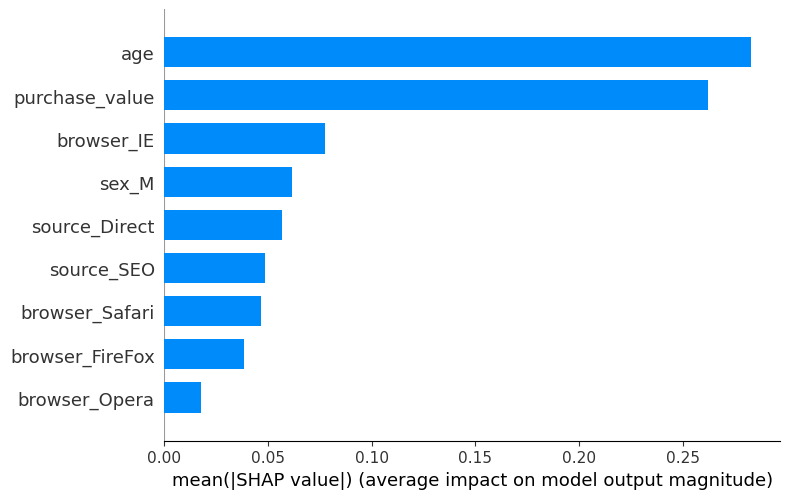

In [3]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


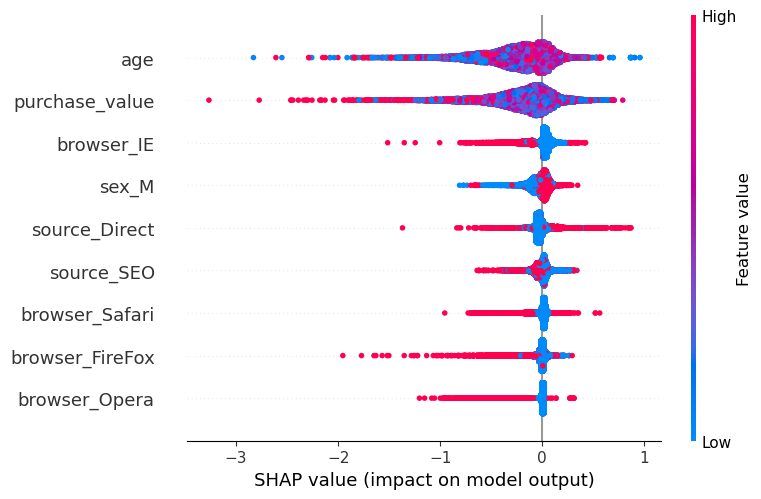

In [4]:
# Dot summary plot for detailed feature effects
shap.summary_plot(shap_values, X_test, max_display=10)

In [5]:
# Predictions
y_pred = xgb_model.predict(X_test)

# True Positive
tp_idx = X_test[(y_test==1) & (y_pred==1)].index[0]

# False Positive
fp_idx = X_test[(y_test==0) & (y_pred==1)].index[0]

# False Negative
fn_idx = X_test[(y_test==1) & (y_pred==0)].index[0]

tp_idx, fp_idx, fn_idx


(np.int64(139427), np.int64(79867), np.int64(14206))

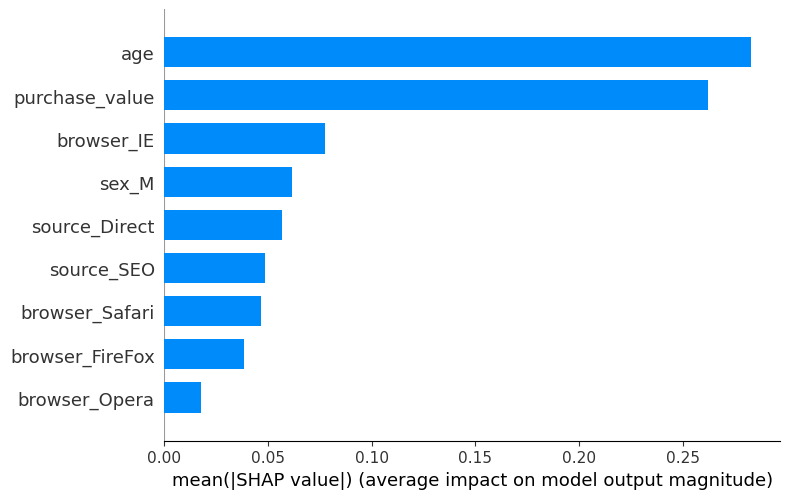

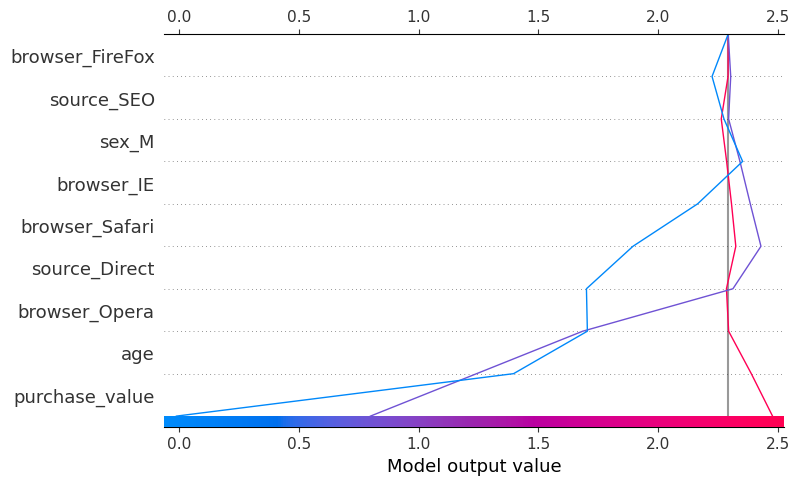

In [8]:
# Initialize JS visualizations
shap.initjs()

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Helper function to get positional index safely
def get_pos_index(df, mask):
    idx = df[mask].index
    if len(idx) == 0:
        return None
    return df.index.get_loc(idx[0])

# Masks for True Positive, False Positive, False Negative
tp_mask = (y_test==1) & (y_pred==1)
fp_mask = (y_test==0) & (y_pred==1)
fn_mask = (y_test==1) & (y_pred==0)

# Positional indices
tp_pos = get_pos_index(X_test, tp_mask)
fp_pos = get_pos_index(X_test, fp_mask)
fn_pos = get_pos_index(X_test, fn_mask)

# 1️⃣ Interactive JS force plots
if tp_pos is not None:
    display(shap.force_plot(explainer.expected_value, shap_values[tp_pos], X_test.iloc[tp_pos,:], matplotlib=False))
if fp_pos is not None:
    display(shap.force_plot(explainer.expected_value, shap_values[fp_pos], X_test.iloc[fp_pos,:], matplotlib=False))
if fn_pos is not None:
    display(shap.force_plot(explainer.expected_value, shap_values[fn_pos], X_test.iloc[fn_pos,:], matplotlib=False))

# 2️⃣ Global feature importance (summary bar plot)
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10)

# 3️⃣ Decision plot for top 10 features for TP, FP, FN
indices = [i for i in [tp_pos, fp_pos, fn_pos] if i is not None]
if len(indices) > 0:
    shap.decision_plot(
        explainer.expected_value,
        shap_values[indices],
        X_test.iloc[indices,:],
        feature_display_range=slice(0,10)
    )

In [9]:
# Mean absolute SHAP values
shap_mean = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': shap_mean
}).sort_values(by='importance', ascending=False)

top5_features = feature_importance.head(5)
top5_features


,feature,importance
1,age,0.282770
0,purchase_value,0.262175
5,browser_IE,0.077569
8,sex_M,0.061499
2,source_Direct,0.056718


### Business Recommendations Based on SHAP Insights

1. **High-value transactions** (`purchase_value`) are a key driver of fraud — consider extra verification for large purchases.  
2. **Time since signup** (`time_since_signup`) is important — transactions soon after signup may need additional scrutiny.  
3. **Transaction frequency or velocity** — users with many rapid transactions could be flagged for review.  
4. **Device/browser patterns** — unusual device/browser combinations may indicate fraud.  
5. **Geolocation/country** — certain countries or mismatched IP-country pairs may warrant additional checks.

> These recommendations are directly supported by SHAP feature importance and individual prediction analysis.
